In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import cv2
from PIL import Image
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from torch import optim
import mlflow
from mlflow.tracking import MlflowClient
import json
import hydra
from omegaconf import DictConfig, OmegaConf
import albumentations as A
import time
import datetime

from utils import *
from implementations import *

import japanize_matplotlib
# pip install japanize-matplotlib

import matplotlib.patches as mpatches
from matplotlib.path import Path
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Yu Mincho', 'Times New Roman']

In [2]:
ename2tname_thesis = {
    "UNet_D-aug1": "ExUnet1",
    "UNet_D-aug5": "ExUnet2",
    "BUNet_D-aug1": "ExBUnet1",
    "BUNet_D-aug5": "ExBUnet2",
    
    "BUNet_UD-aug1": "ExBUnet3",
    "BUNet_UD-aug5": "ExBUnet4",
    
    "BUNet_UD2-aug1": "ExBUnet3",
    "BUNet_UD2-aug5": "ExBUnet4",
}

ename2tname_ppt = {
    "UNet_D-aug1": "U-Net",
    "UNet_D-aug5": "U-Net + D",
    "BUNet_D-aug1": "Bayesian U-Net",
    "BUNet_D-aug5": "Bayesian U-Net + D",
    
    "BUNet_UD-aug1": "Bayesian U-Net + L",
    "BUNet_UD-aug5": "Bayesian U-Net + D + L",
    
    "BUNet_UD2-aug1": "Bayesian U-Net + L",
    "BUNet_UD2-aug5": "Bayesian U-Net + D + L",
}

In [3]:
ROOT_MLRUNS = "mlruns"
ROOT_SAVE = "results"

EXPERIMENT_NAMES = [
    "UNet_D-aug1", "UNet_D-aug5", "UNet_D-aug2", "UNet_D-aug3",
    "BUNet_UD-aug1", "BUNet_UD-aug5", "BUNet_UD-aug2", "BUNet_UD-aug3",
                   ]

EXPERIMENT_NAMES = [
    "UNet_D-aug1", "UNet_D-aug5",
    "BUNet_D-aug1", "BUNet_D-aug5",
    "BUNet_UD2-aug1", "BUNet_UD2-aug5"
                   ]

# EXPERIMENT_NAMES = [
#     "UNet_D-aug1",
#                    ]

N_FOLDS = 3
PLOT_METRICS = [("metrics_1fold", "Train Metrics 1 fold", "Valid Metrics 1 fold"), ("metrics_2fold", "Train Metrics 2 fold", "Valid Metrics 2 fold"), ("metrics_3fold", "Train Metrics 3 fold", "Valid Metrics 3 fold")]
EVALUATE_METRICS = [("f", "Test F"), ("precision", "Test Precision"), ("recall", "Test Recall")] #("auc", "Test AUC")

In [4]:
 for experiment_name in EXPERIMENT_NAMES:
    experiment_root = os.path.join(ROOT_SAVE, experiment_name)
    try:
        os.mkdir(experiment_root)
    except:
        pass

In [5]:
def pm2legend(pm):
    pms = pm.split(" ")
    t_or_v = pms[0]
    i_fold = pms[-2]
    data_name = {
        "Train": "訓練用データ",
        "Valid": "検証用データ"
    }[t_or_v]
    return "{} {}fold".format(data_name, i_fold) 

In [6]:
def save_learning_curve_data():
    client = MlflowClient()
    for experiment_name in EXPERIMENT_NAMES:
        print(experiment_name)
        for plot_ms in PLOT_METRICS:
            experiment = client.get_experiment_by_name(experiment_name)
            experiment_id = experiment.experiment_id
            runs = client.list_run_infos(experiment_id)
            n_runs = len(runs)

            average_train_x_step = []
            average_train_y_value = []
            average_valid_x_step = []
            average_valid_y_value = []
            for i in range(n_runs):
                run = runs[i]
                run_id = run.run_id
                if run.status != "FINISHED":
                    print("{} is running or failed".format(run_id))
                    continue

                train_metric_data = client.get_metric_history(run_id, plot_ms[1])
                valid_metric_data = client.get_metric_history(run_id, plot_ms[2])
                n_data = len(train_metric_data) if len(train_metric_data) == len(valid_metric_data) else -1
                train_x_step = []
                train_y_value = []
                valid_x_step = []
                valid_y_value = []
                for i in range(n_data):
                    train_metric_d = train_metric_data[i]
                    train_x_step.append(train_metric_d.step)
                    train_y_value.append(train_metric_d.value)

                    valid_metric_d = valid_metric_data[i]
                    valid_x_step.append(valid_metric_d.step)
                    valid_y_value.append(valid_metric_d.value)

                average_train_x_step.append(train_x_step)
                average_train_y_value.append(train_y_value)
                average_valid_x_step.append(valid_x_step)
                average_valid_y_value.append(valid_y_value)

            # list -> np.array   
            average_train_x_step = np.array(average_train_x_step).mean(axis=0).astype(np.int)
            average_train_y_value = np.array(average_train_y_value).mean(axis=0)
            average_valid_x_step = np.array(average_valid_x_step).mean(axis=0).astype(np.int)
            average_valid_y_value = np.array(average_valid_y_value).mean(axis=0)
            df_data = pd.DataFrame({
                "train_epoch": average_train_x_step,
                "train_value": average_train_y_value,
                "valid_epoch": average_valid_x_step,
                "valid_value": average_valid_y_value
            })
            df_data.to_csv(os.path.join(ROOT_SAVE, "{}/{}.csv".format(experiment_name, plot_ms[0])), index=False)

            plt.figure(figsize=(7, 5))
            plt.xlim(0, n_data)
            plt.ylim(0, 1)
            plt.grid(True)
            plt.plot(average_train_x_step, average_train_y_value, label=pm2legend(plot_ms[1]))
            plt.plot(average_valid_x_step, average_valid_y_value, label=pm2legend(plot_ms[2]))
            
            plt.xticks(np.arange(0, n_data+0.1, 10))
            plt.yticks(np.arange(0, 1.01, 0.2))
            plt.tick_params(labelsize=25)
            plt.xlabel("Epoch", fontsize=30)
            plt.ylabel("F値", fontsize=30)
            plt.legend(prop={"size": 25}, loc="lower right")
            
            plt.savefig(os.path.join(ROOT_SAVE, "{}/{}.png".format(experiment_name, plot_ms[0])), bbox_inches='tight')
            plt.savefig(os.path.join(ROOT_SAVE, "{}/{}.pdf".format(experiment_name, plot_ms[0])), bbox_inches='tight')
            plt.show()

UNet_D-aug1


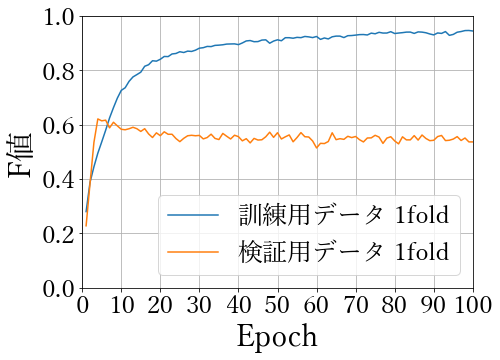

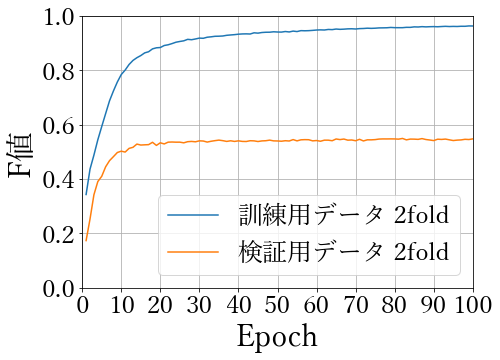

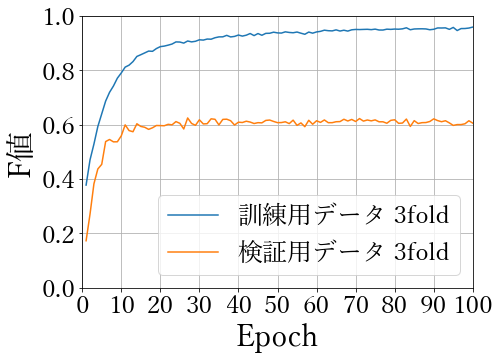

UNet_D-aug5


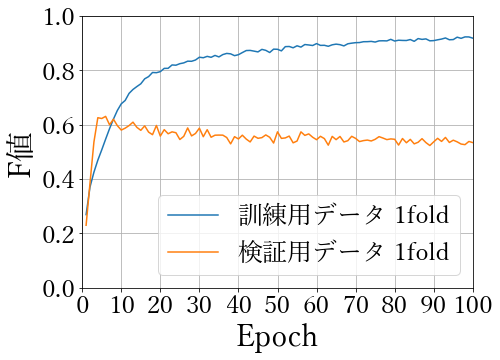

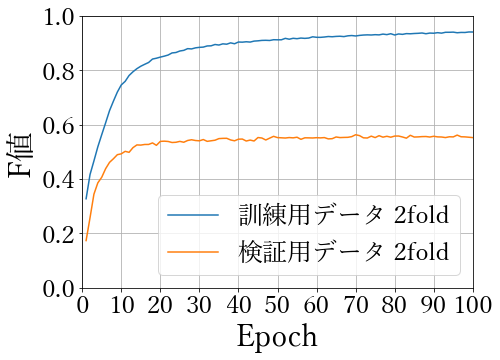

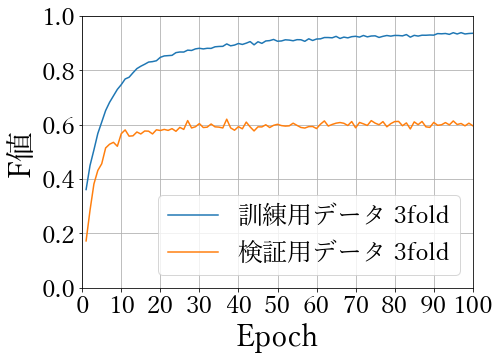

BUNet_D-aug1


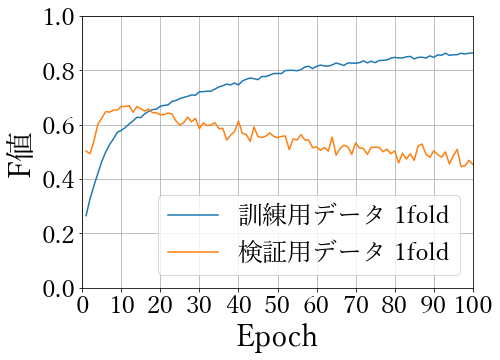

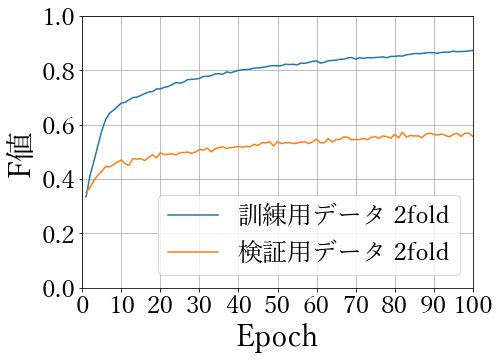

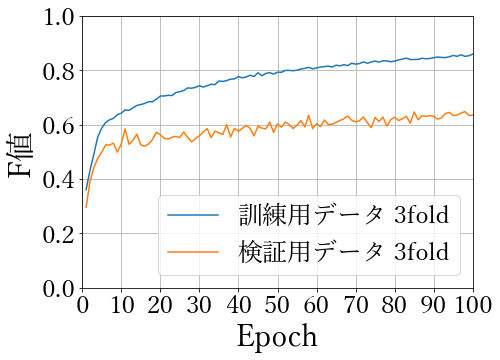

BUNet_D-aug5


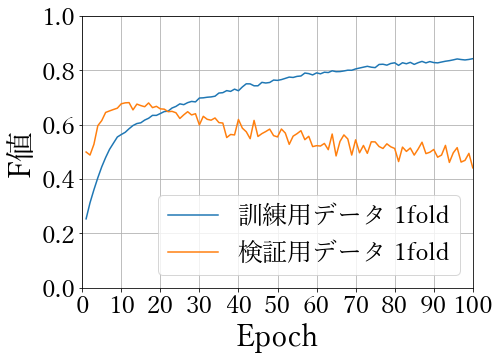

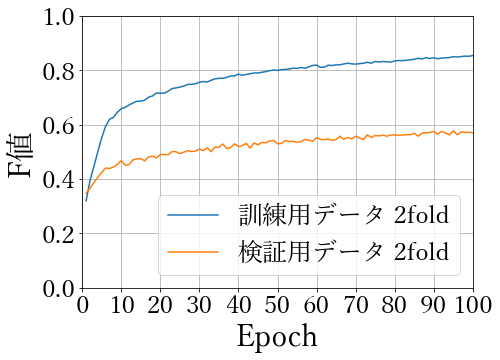

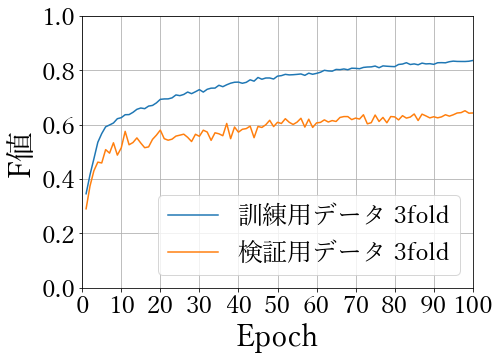

BUNet_UD2-aug1


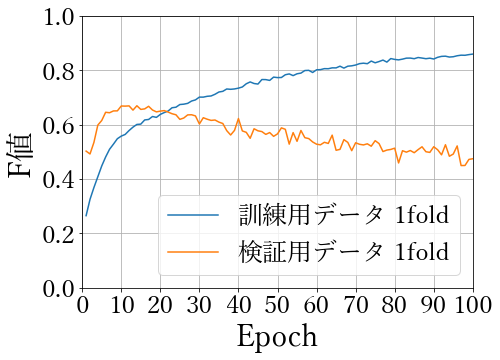

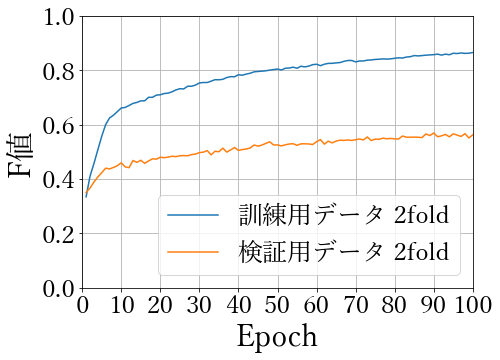

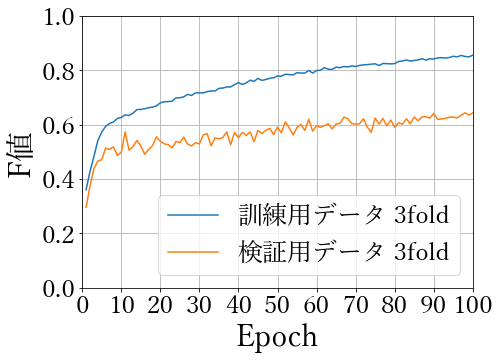

BUNet_UD2-aug5


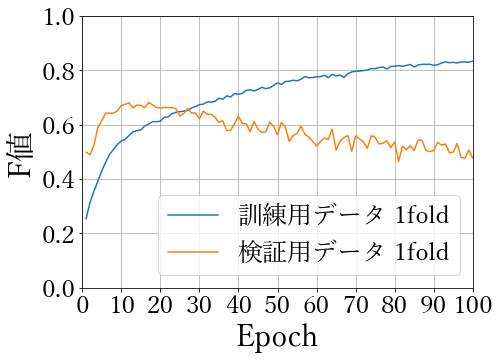

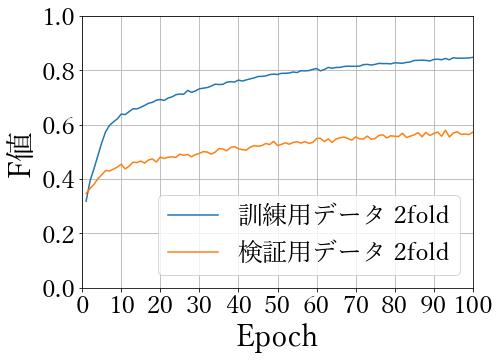

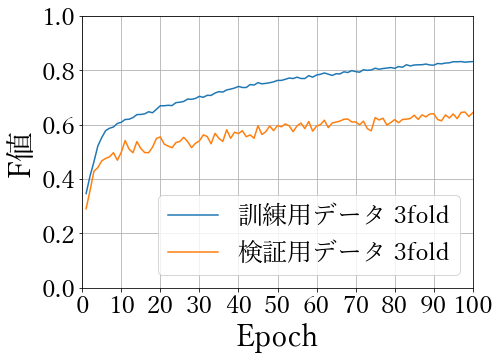

In [7]:
save_learning_curve_data()

In [8]:
def save_metrics_data():
    client = MlflowClient()
    for experiment_name in EXPERIMENT_NAMES:
        print(experiment_name)
        experiment = client.get_experiment_by_name(experiment_name)
        experiment_id = experiment.experiment_id
        runs = client.list_run_infos(experiment_id)
        n_runs = len(runs)

        dict_metrics = {evaluate_m[0]: [] for evaluate_m in EVALUATE_METRICS}
        dict_metrics["seed"] = []
        for i in range(n_runs):
            run = runs[i]
            run_id = run.run_id
            if run.status != "FINISHED":
                print("{} is running or failed".format(run_id))
                continue
                
            seed = client.get_run(run_id).data.tags["seed"]
            dict_metrics["seed"].append(seed)

            for evaluate_m in EVALUATE_METRICS:
                metric_d = client.get_metric_history(run_id, evaluate_m[1])[0]
                dict_metrics[evaluate_m[0]].append(metric_d.value)

        # list -> np.array  
        df_data = pd.DataFrame(dict_metrics)
        df_data.to_csv(os.path.join(ROOT_SAVE, "{}/{}.csv".format(experiment_name, "fundamental_metrics")), index=False)

        # NOT SAVE HERE
        plt.figure(figsize=(7, 5))
        plt.ylim(0.5, 1)
        sns.boxplot(x="variable", y="value", data=pd.melt(df_data.drop(columns=["seed"])))
        plt.grid(True)
        plt.show()

UNet_D-aug1


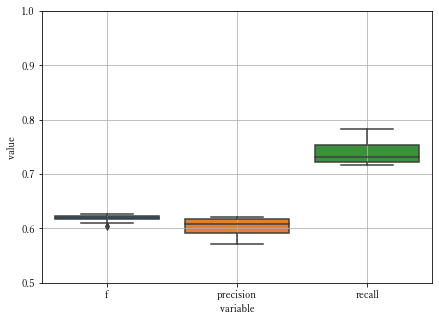

UNet_D-aug5


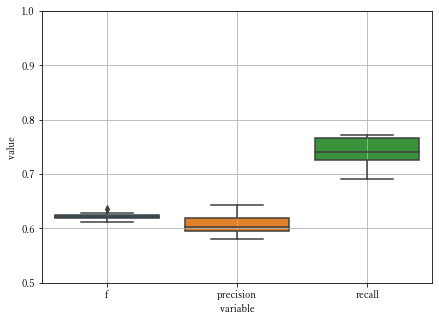

BUNet_D-aug1


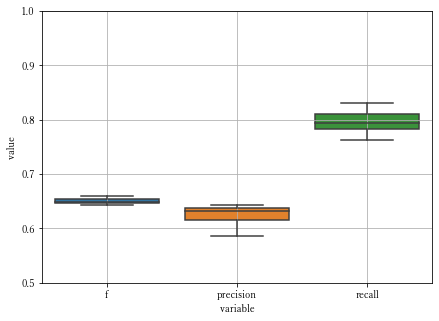

BUNet_D-aug5


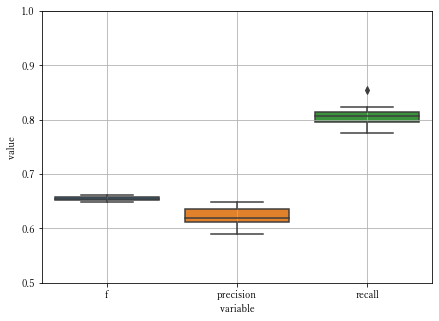

BUNet_UD2-aug1


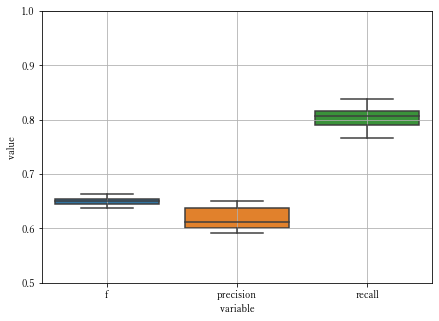

BUNet_UD2-aug5


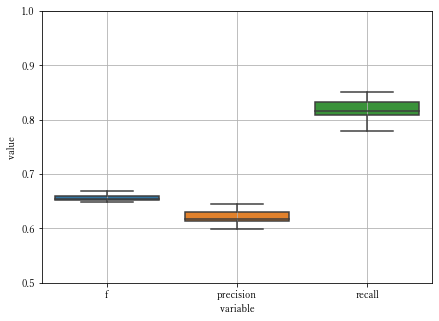

In [9]:
save_metrics_data()

In [10]:
def compare_metrics_by_experiments():
    df_data_cat = pd.DataFrame()
    for experiment_name in EXPERIMENT_NAMES:
        data_path = os.path.join(ROOT_SAVE, "{}/{}.csv".format(experiment_name, "fundamental_metrics"))
        df_data = pd.read_csv(data_path)
        df_data["experiment_name"] = experiment_name
        df_data_cat = pd.concat([df_data_cat, df_data], axis=0)
        
    df_mean = df_data_cat.groupby("experiment_name").mean().reset_index()
    df_std = df_data_cat.groupby("experiment_name").std().reset_index()
    
    # Experiment
    for experiment_name in EXPERIMENT_NAMES:
        cols = df_mean.columns
        metrics_mean = df_mean.query("experiment_name == '{}'".format(experiment_name)).values.flatten()
        metrics_std = df_std.query("experiment_name == '{}'".format(experiment_name)).values.flatten()
        metrics_str = ""
        metrics_str += "experiment {} \n".format(experiment_name) 
        for i in range(1, len(metrics_mean)):
            metric_str = "{:.3f}±{:.3f}".format(metrics_mean[i], metrics_std[i])
            metrics_str += "\t {}: {}\n".format(cols[i], metric_str)
        print(metrics_str)

    for evaluate_m in EVALUATE_METRICS:
        print(evaluate_m[0])
        plt.figure(figsize=(12, 5))
        sns.boxplot(x="experiment_name", y=evaluate_m[0], data=df_data_cat)
        sns.stripplot(x="experiment_name", y=evaluate_m[0], data=df_data_cat, color='black')
        plt.grid(True)
#         plt.savefig(os.path.join(ROOT_SAVE, "{}/compre_{}.png".format(experiment_name, evaluate_m[0])))
        plt.show()

experiment UNet_D-aug1 
	 f: 0.618±0.006
	 precision: 0.604±0.018
	 recall: 0.739±0.022
	 seed: 83.400±57.820

experiment UNet_D-aug5 
	 f: 0.622±0.006
	 precision: 0.607±0.021
	 recall: 0.741±0.028
	 seed: 83.400±57.820

experiment BUNet_D-aug1 
	 f: 0.651±0.006
	 precision: 0.625±0.018
	 recall: 0.796±0.021
	 seed: 83.400±57.820

experiment BUNet_D-aug5 
	 f: 0.655±0.004
	 precision: 0.622±0.017
	 recall: 0.808±0.021
	 seed: 83.400±57.820

experiment BUNet_UD2-aug1 
	 f: 0.650±0.008
	 precision: 0.617±0.021
	 recall: 0.805±0.022
	 seed: 83.400±57.820

experiment BUNet_UD2-aug5 
	 f: 0.657±0.006
	 precision: 0.621±0.013
	 recall: 0.818±0.021
	 seed: 83.400±57.820

f


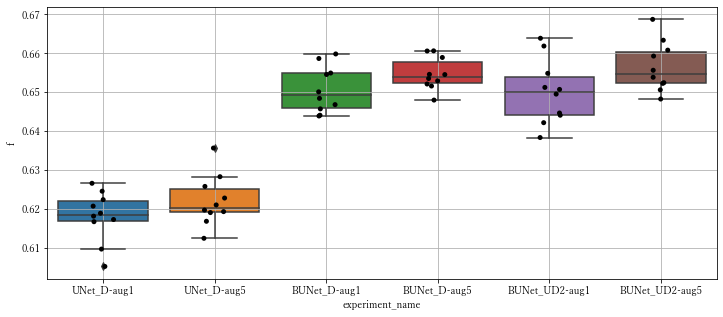

precision


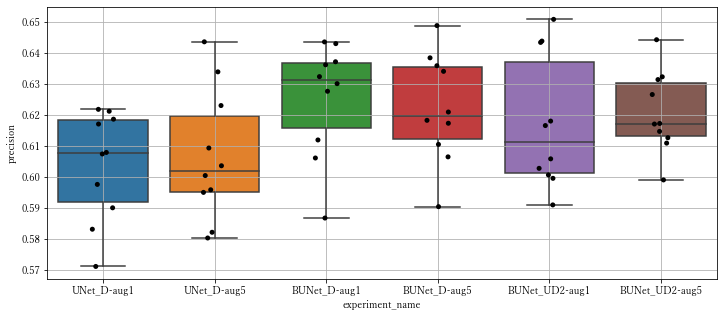

recall


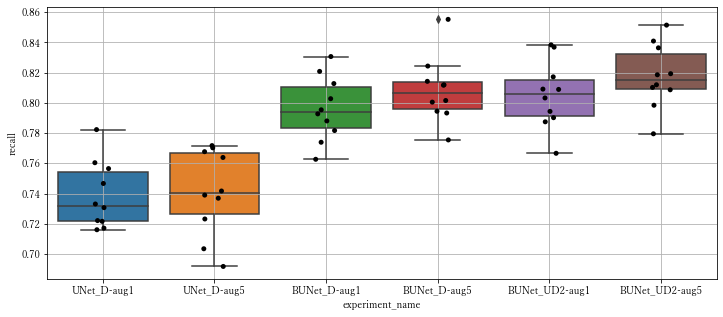

In [11]:
compare_metrics_by_experiments()

In [12]:
def remake_roc_xy(df_roc):
    roc_x, roc_y = df_roc["roc_x"].values.tolist(), df_roc["roc_y"].values.tolist()
    roc_z = list(set([(0.0, 0.0)] + list(zip(roc_x, roc_y)) + [(1.0, 1.0)]))
    roc_z = sorted(roc_z, key=lambda z: z[0])
    roc_x = [z[0] for z in roc_z]
    roc_y = [z[1] for z in roc_z]
    return roc_x, roc_y    

def auc_using_roc_curve(roc):
    roc_x = roc[0]
    roc_y = roc[1]
    n = len(roc_x)
    auc = abs(sum(roc_x[i-1]*roc_y[i] - roc_x[i]*roc_y[i-1] for i in range(n))) / 2 + 0.5
    return auc

def auc_using_df_roc(df_roc):
    roc = remake_roc_xy(df_roc)
    auc = auc_using_roc_curve(roc)
    return auc

In [35]:
def save_roc_curve():
    client = MlflowClient()
    experiment_auc_dict = {experiment_name: [] for experiment_name in EXPERIMENT_NAMES}
    experiment_auc_by_run_dict = {experiment_name: [] for experiment_name in EXPERIMENT_NAMES}
    experiment_seed_by_run_dict = {experiment_name: [] for experiment_name in EXPERIMENT_NAMES}
    for experiment_name in EXPERIMENT_NAMES:
        print(experiment_name)
        experiment = client.get_experiment_by_name(experiment_name)
        experiment_id = experiment.experiment_id
        runs = client.list_run_infos(experiment_id)
        n_runs = len(runs)

        fold_roc_dict = {i: [] for i in range(1, N_FOLDS+1)}
        fold_auc_dict = {i: [] for i in range(1, N_FOLDS+1)}
        runs_auc_list = []
        
        for i in range(n_runs):
            run = runs[i]
            run_id = run.run_id
            if run.status != "FINISHED":
                print("{} is running or failed".format(run_id))
                continue

            run_aucs = []
            for j in range(1, N_FOLDS+1):
                roc_data_path = os.path.join(ROOT_MLRUNS, experiment_id, run_id, "artifacts/{}_fold".format(j), "roc_data.csv")
                try:
                    df_roc = pd.read_csv(roc_data_path)
                    df_roc = df_roc[["roc_x", "roc_y"]]
                    auc = auc_using_df_roc(df_roc)
                    fold_roc_dict[j].append(df_roc)
                    fold_auc_dict[j].append(auc)
                    run_aucs.append(auc)
                except FileNotFoundError:
                    print("Missing File {}".format(roc_data_path))
            experiment_auc_by_run_dict[experiment_name].append(np.mean(run_aucs))
            seed = client.get_run(run_id).data.tags["seed"]
            experiment_seed_by_run_dict[experiment_name].append(seed)

        df_rocs = []
        for i in range(1, N_FOLDS+1):
            experiment_auc_dict[experiment_name] += fold_auc_dict[i]
            df_roc = sum(fold_roc_dict[i]) / len(fold_roc_dict[i])
            df_rocs.append(df_roc)
            roc_x, roc_y = remake_roc_xy(df_roc)
            aucs = fold_auc_dict[i]
            auc_mean = np.mean(aucs)
            auc_std = np.std(aucs)
            df_roc_curve = pd.DataFrame({
                "roc_x": roc_x,
                "roc_y": roc_y
            })
            df_roc_curve.to_csv(os.path.join(ROOT_SAVE, "{}/average_roc_curve_{}fold.csv".format(experiment_name, i)), index=False)
            plt.xlim(0, 1)
            plt.ylim(0, 1)
#             plt.title("AUC score {:.3f}±{:.3f}".format(auc_mean, auc_std), fontsize=25)
#             plt.plot(roc_x, roc_y, label="ROC curve {} fold".format(i))
            plt.plot(roc_x, roc_y)
            plt.scatter(roc_x, roc_y)
            plt.grid(True)
            
            plt.xticks(np.arange(0, 1.01, 0.2))
            plt.yticks(np.arange(0, 1.01, 0.2))
            plt.tick_params(labelsize=25)
            plt.xlabel("1 - specificity", fontsize=30)
            plt.ylabel("sensitivity", fontsize=30)
#             plt.legend(prop={"size": 20}, loc="lower right")
#             plt.legend(prop={"size": 20})
    
            plt.savefig(os.path.join(ROOT_SAVE, "{}/average_roc_curve_{}fold.png".format(experiment_name, i)), bbox_inches='tight')
            plt.savefig(os.path.join(ROOT_SAVE, "{}/average_roc_curve_{}fold.pdf".format(experiment_name, i)), bbox_inches='tight')
#             plt.savefig(os.path.join(ROOT_SAVE, "{}/average_roc_curve.png".format(experiment_name)))
            plt.show()
    
    
        ##### Total ROC Curve #####
        df_roc = sum(df_rocs) / len(df_rocs)
        roc_x, roc_y = remake_roc_xy(df_roc)
        df_roc_curve = pd.DataFrame({
            "roc_x": roc_x,
            "roc_y": roc_y
        })
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.title("{}".format(ename2tname_ppt[experiment_name]), fontsize=25)
        plt.plot(roc_x, roc_y)
        plt.scatter(roc_x, roc_y)
        plt.grid(True)

        plt.xticks(np.arange(0, 1.01, 0.2))
        plt.yticks(np.arange(0, 1.01, 0.2))
        plt.tick_params(labelsize=25)
#         plt.xlabel("1 - specificity", fontsize=30)
#         plt.ylabel("sensitivity", fontsize=30)

        plt.savefig(os.path.join(ROOT_SAVE, "{}/average_roc_curve.png".format(experiment_name)), bbox_inches='tight')
#         plt.savefig(os.path.join(ROOT_SAVE, "{}/average_roc_curve.pdf".format(experiment_name)), bbox_inches='tight')
        plt.show()
        ##### #####
            

    df_experiment_auc_by_run = pd.DataFrame()
    for experiment_name in EXPERIMENT_NAMES:
        df_experiment_auc_by_run_tmp = pd.DataFrame({
            "experiment_name": [],
            "AUC": [],
            "seed": []
        })
        aucs = experiment_auc_by_run_dict[experiment_name]
        seeds = experiment_seed_by_run_dict[experiment_name]
        df_experiment_auc_by_run_tmp["experiment_name"] = [experiment_name] * len(aucs)
        df_experiment_auc_by_run_tmp["AUC"] = aucs
        df_experiment_auc_by_run_tmp["seed"] = seeds
        df_experiment_auc_by_run_tmp.to_csv(os.path.join(ROOT_SAVE, "{}/{}.csv".format(experiment_name, "fundamental_auc_metrics")), index=False)
        df_experiment_auc_by_run = pd.concat([df_experiment_auc_by_run, df_experiment_auc_by_run_tmp], axis=0)
        
    plt.figure(figsize=(12, 5))
    sns.boxplot(x="experiment_name", y="AUC", data=df_experiment_auc_by_run)
    sns.stripplot(x="experiment_name", y="AUC", data=df_experiment_auc_by_run, color='black')
    plt.grid(True)
            
#     plt.savefig(os.path.join(ROOT_SAVE, "{}/compre_{}.png".format(experiment_name, "AUC")))
    plt.show()
    
    for experiment_name in EXPERIMENT_NAMES:
        aucs = experiment_auc_dict[experiment_name]
        auc_mean = np.mean(aucs)
        auc_std = np.std(aucs)
        print("{}: AUC score {:.3f}±{:.3f}".format(experiment_name, auc_mean, auc_std))
        print()

UNet_D-aug1


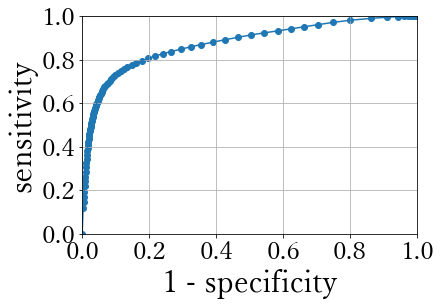

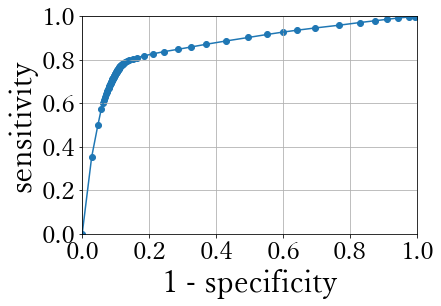

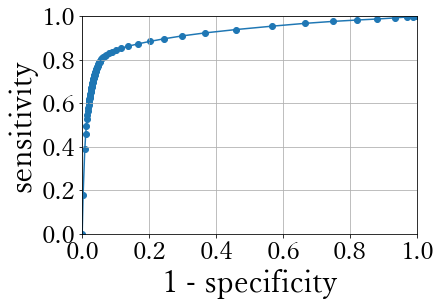

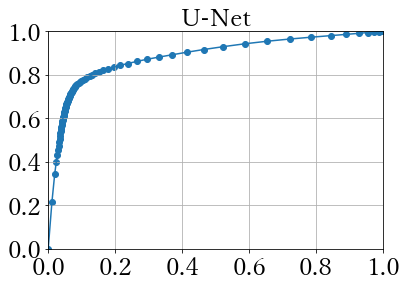

UNet_D-aug5


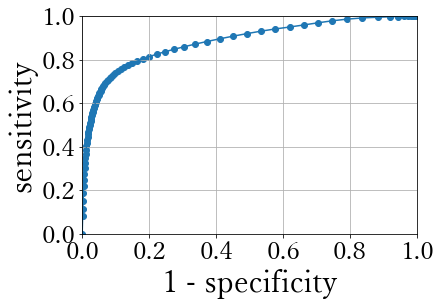

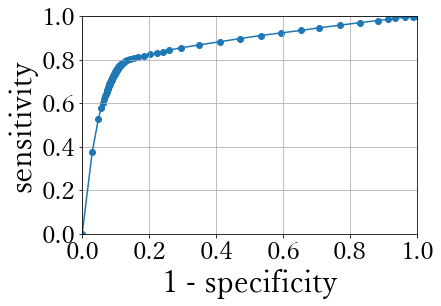

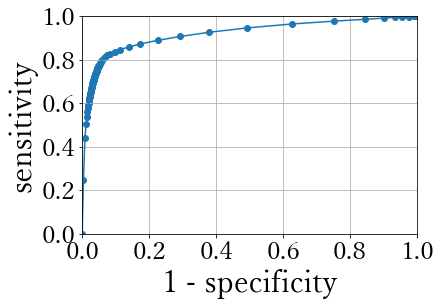

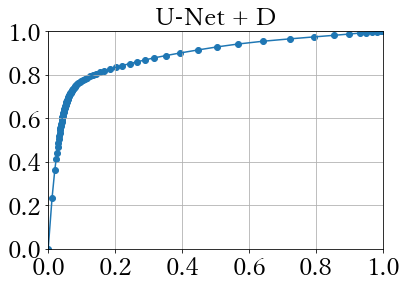

BUNet_D-aug1


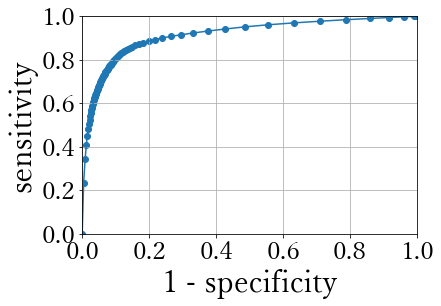

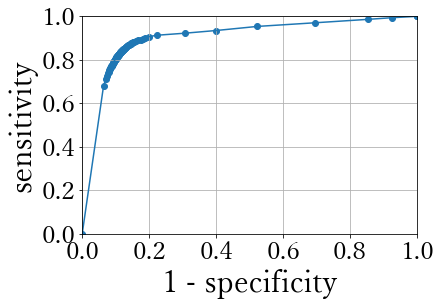

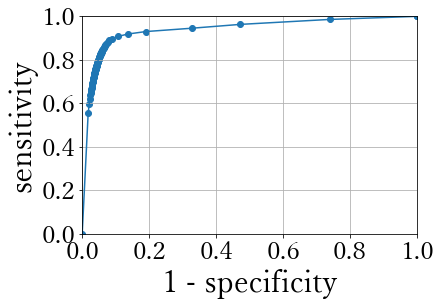

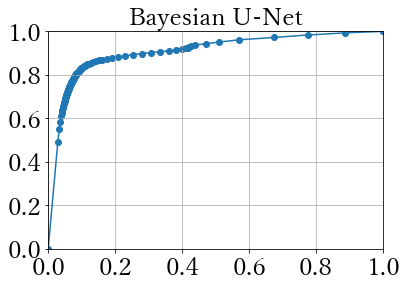

BUNet_D-aug5


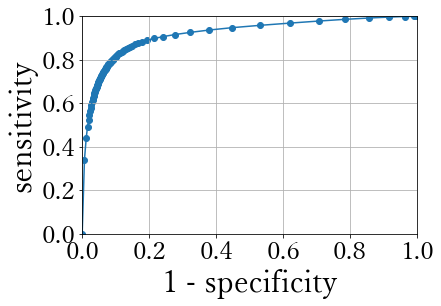

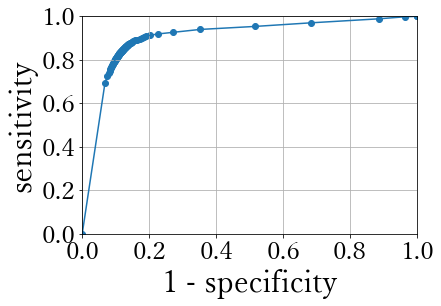

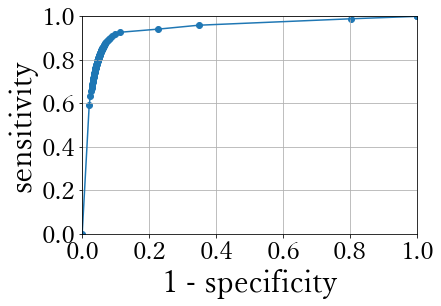

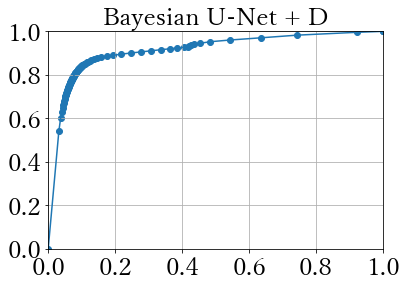

BUNet_UD2-aug1


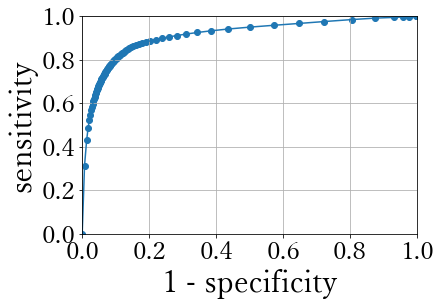

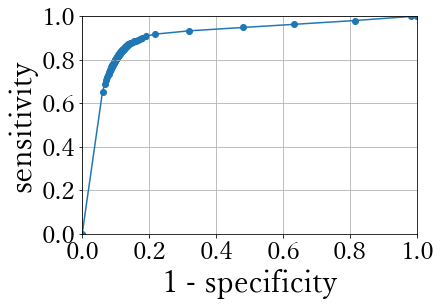

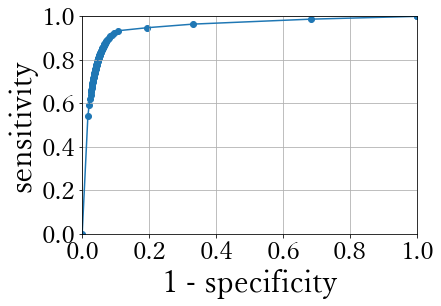

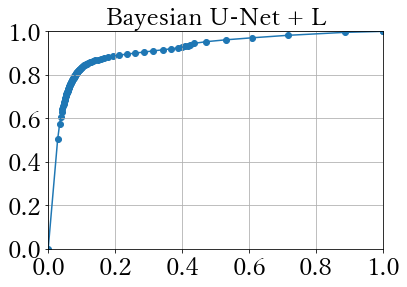

BUNet_UD2-aug5


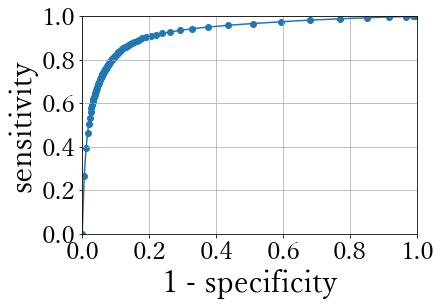

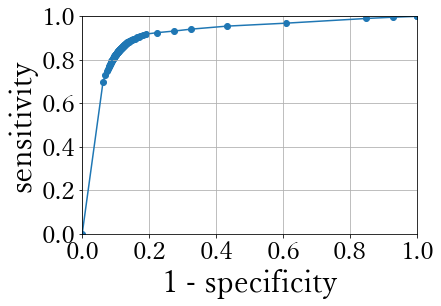

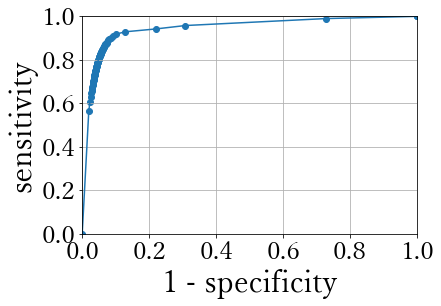

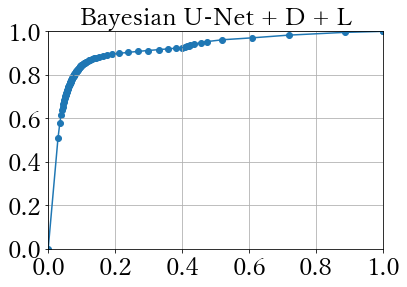

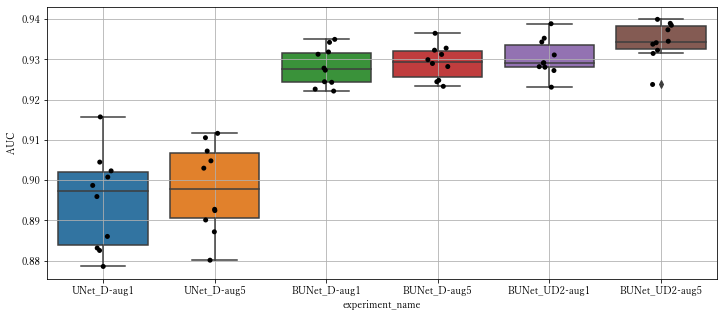

UNet_D-aug1: AUC score 0.895±0.029

UNet_D-aug5: AUC score 0.898±0.025

BUNet_D-aug1: AUC score 0.928±0.017

BUNet_D-aug5: AUC score 0.929±0.017

BUNet_UD2-aug1: AUC score 0.930±0.019

BUNet_UD2-aug5: AUC score 0.934±0.015



In [36]:
save_roc_curve()

In [15]:
client = MlflowClient()
experiment_name = EXPERIMENT_NAMES[0]
print(experiment_name)
experiment = client.get_experiment_by_name(experiment_name)
experiment_id = experiment.experiment_id
runs = client.list_run_infos(experiment_id)
n_runs = len(runs)
run = runs[0]
run_id = run.run_id
run.status

UNet_D-aug1


'FINISHED'

In [16]:
def maketextable(experiment_name):
    client = MlflowClient()
    print(experiment_name)
    experiment = client.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id
    runs = client.list_run_infos(experiment_id)
    n_runs = len(runs)
    run = runs[0]
    run_id = run.run_id
    run.status
    df_fm = pd.read_csv(os.path.join(ROOT_SAVE, experiment_name, "fundamental_metrics.csv"))
    df_auc_fm =  pd.read_csv(os.path.join(ROOT_SAVE, experiment_name, "fundamental_auc_metrics.csv"))
    df_metric_table = pd.merge(df_auc_fm, df_fm, how='left', on="seed")
    df_metric_table[["seed", "experiment_name", "precision", "recall", "f", "AUC"]].to_csv(os.path.join(ROOT_SAVE, experiment_name, "total_metrics.csv"), index=False)
    
    print("all data")
    print("-"*50)
    tables = df_metric_table[["seed", "precision", "recall", "f", "AUC"]].sort_values(by="seed").values.tolist()
    code = ""
    code += r" & seed & 適合率 & 再現率 & F値 & AUC \\ \hline\hline"
    code += "\n"
    for i, row in enumerate(tables):
        code += r"${}$ & ${}$ & ${:0.3f}$ & ${:.3f}$ & ${:.3f}$ & ${:.3f}$ \\ \hline".format(i+1, int(row[0]), row[1], row[2], row[3], row[4])
        code += "\n"
    print(code)
    print()
    
    print("mean and std")
    print("-"*50)
    mean = df_metric_table.groupby("experiment_name")[["precision", "recall", "f", "AUC"]].mean().values.flatten().tolist()
    std = df_metric_table.groupby("experiment_name")[["precision", "recall", "f", "AUC"]].std().values.flatten().tolist()
    code = ""
    code += r"実験名 & 適合率 & 再現率 & F値 & AUC \\ \hline\hline"
    code += "\n"
    code += r"{}(変更の必要あり) & ${:.3f}\pm{:.3f}$ & ${:.3f}\pm{:.3f}$ & ${:.3f}\pm{:.3f}$ & ${:.3f}\pm{:.3f}$ \\ \hline".format(experiment_name, mean[0], std[0], mean[1], std[1], mean[2], std[2], mean[3], std[3])
    print(code)
    print()

In [17]:
maketextable("UNet_D-aug5")

UNet_D-aug5
all data
--------------------------------------------------
 & seed & 適合率 & 再現率 & F値 & AUC \\ \hline\hline
$1$ & $17$ & $0.604$ & $0.739$ & $0.619$ & $0.892$ \\ \hline
$2$ & $25$ & $0.609$ & $0.723$ & $0.621$ & $0.893$ \\ \hline
$3$ & $47$ & $0.595$ & $0.770$ & $0.628$ & $0.905$ \\ \hline
$4$ & $55$ & $0.600$ & $0.764$ & $0.626$ & $0.912$ \\ \hline
$5$ & $59$ & $0.596$ & $0.737$ & $0.613$ & $0.890$ \\ \hline
$6$ & $73$ & $0.580$ & $0.772$ & $0.619$ & $0.907$ \\ \hline
$7$ & $81$ & $0.634$ & $0.692$ & $0.620$ & $0.880$ \\ \hline
$8$ & $120$ & $0.623$ & $0.742$ & $0.636$ & $0.903$ \\ \hline
$9$ & $178$ & $0.582$ & $0.768$ & $0.617$ & $0.911$ \\ \hline
$10$ & $179$ & $0.644$ & $0.703$ & $0.623$ & $0.887$ \\ \hline


mean and std
--------------------------------------------------
実験名 & 適合率 & 再現率 & F値 & AUC \\ \hline\hline
UNet_D-aug5(変更の必要あり) & $0.607\pm0.021$ & $0.741\pm0.028$ & $0.622\pm0.006$ & $0.898\pm0.011$ \\ \hline



In [18]:
def allmaketextable():
    print("mean and std")
    print("-"*50)
    
    code = ""
    code += r"実験名 & 適合率 & 再現率 & F値 & AUC \\ \hline\hline"
    code += "\n"
    for experiment_name in EXPERIMENT_NAMES:
        df_fm = pd.read_csv(os.path.join(ROOT_SAVE, experiment_name, "fundamental_metrics.csv"))
        df_auc_fm =  pd.read_csv(os.path.join(ROOT_SAVE, experiment_name, "fundamental_auc_metrics.csv"))
        df_metric_table = pd.merge(df_auc_fm, df_fm, how='left', on="seed")
        df_metric_table[["seed", "experiment_name", "precision", "recall", "f", "AUC"]].to_csv(os.path.join(ROOT_SAVE, experiment_name, "total_metrics.csv"), index=False)

        mean = df_metric_table.groupby("experiment_name")[["precision", "recall", "f", "AUC"]].mean().values.flatten().tolist()
        std = df_metric_table.groupby("experiment_name")[["precision", "recall", "f", "AUC"]].std().values.flatten().tolist()
        code += r"{}(変更の必要あり) & ${:.3f}\pm{:.3f}$ & ${:.3f}\pm{:.3f}$ & ${:.3f}\pm{:.3f}$ & ${:.3f}\pm{:.3f}$ \\ \hline".format(experiment_name, mean[0], std[0], mean[1], std[1], mean[2], std[2], mean[3], std[3])
        code += "\n"
    
    print(code)
    print()

In [19]:
allmaketextable()

mean and std
--------------------------------------------------
実験名 & 適合率 & 再現率 & F値 & AUC \\ \hline\hline
UNet_D-aug1(変更の必要あり) & $0.604\pm0.018$ & $0.739\pm0.022$ & $0.618\pm0.006$ & $0.895\pm0.012$ \\ \hline
UNet_D-aug5(変更の必要あり) & $0.607\pm0.021$ & $0.741\pm0.028$ & $0.622\pm0.006$ & $0.898\pm0.011$ \\ \hline
BUNet_D-aug1(変更の必要あり) & $0.625\pm0.018$ & $0.796\pm0.021$ & $0.651\pm0.006$ & $0.928\pm0.005$ \\ \hline
BUNet_D-aug5(変更の必要あり) & $0.622\pm0.017$ & $0.808\pm0.021$ & $0.655\pm0.004$ & $0.929\pm0.004$ \\ \hline
BUNet_UD2-aug1(変更の必要あり) & $0.617\pm0.021$ & $0.805\pm0.022$ & $0.650\pm0.008$ & $0.930\pm0.005$ \\ \hline
BUNet_UD2-aug5(変更の必要あり) & $0.621\pm0.013$ & $0.818\pm0.021$ & $0.657\pm0.006$ & $0.934\pm0.005$ \\ \hline




In [20]:
ename2tname = {
    "UNet_D-aug1": "ExUnet1",
    "UNet_D-aug5": "ExUnet2",
    "BUNet_D-aug1": "ExBUnet1",
    "BUNet_D-aug5": "ExBUnet2",
    
    "BUNet_UD-aug1": "ExBUnet3",
    "BUNet_UD-aug5": "ExBUnet4",
    
    "BUNet_UD2-aug1": "ExBUnet3",
    "BUNet_UD2-aug5": "ExBUnet4",
}

ename2tname = {
    "UNet_D-aug1": "U-Net",
    "UNet_D-aug5": "U-Net + D",
    "BUNet_D-aug1": "Bayesian U-Net",
    "BUNet_D-aug5": "Bayesian U-Net + D",
    
    "BUNet_UD-aug1": "Bayesian U-Net + L",
    "BUNet_UD-aug5": "Bayesian U-Net + D + L",
    
    "BUNet_UD2-aug1": "Bayesian U-Net + L",
    "BUNet_UD2-aug5": "Bayesian U-Net + D + L",
}

mname2tname = {
    "precision": "適合率",
    "recall": "再現率",
    "f": "F値",
    "AUC": "AUC"
}

mname2aname = {
    "precision": "a",
    "recall": "b",
    "f": "c",
    "AUC": "d",
}
aname2mname = {v: k for k, v in mname2aname.items()}

ename2aname = {
    "UNet_D-aug1": "a",
    "UNet_D-aug5": "b",
    "BUNet_D-aug1": "c",
    "BUNet_D-aug5": "e",
    
    "BUNet_UD-aug1": "d",
    "BUNet_UD-aug5": "f",
    
    "BUNet_UD2-aug1": "d",
    "BUNet_UD2-aug5": "f",
}
aname2ename = {v: k for k, v in ename2aname.items()}

In [21]:
COMPARE_EXPERIMENT_NAMES = [
    "UNet_D-aug1", "UNet_D-aug5",
]

COMPARE_EXPERIMENT_NAMES = [
    "UNet_D-aug1", "UNet_D-aug5",
    "BUNet_D-aug1", "BUNet_D-aug5",
    "BUNet_UD2-aug1", "BUNet_UD2-aug5",
]

# COMPARE_EXPERIMENT_NAMES = [
#     "BUNet_D-aug1", "BUNet_UD-aug1"
# ]

In [22]:
def draw_boxplot():
    df_metric_boxplots = pd.DataFrame()
    for experiment_name in COMPARE_EXPERIMENT_NAMES:
        print(experiment_name)
        df_fm = pd.read_csv(os.path.join(ROOT_SAVE, experiment_name, "fundamental_metrics.csv"))
        df_auc_fm =  pd.read_csv(os.path.join(ROOT_SAVE, experiment_name, "fundamental_auc_metrics.csv"))
        df_metric_table = pd.merge(df_auc_fm, df_fm, how='left', on="seed")
        df_metric_boxplot = df_metric_table.drop(columns=["seed"]).melt(id_vars=["experiment_name"], var_name=["metric"], value_name="score")
        
        df_metric_boxplots = pd.concat([df_metric_boxplots, df_metric_boxplot], axis=0)
    
    df_metric_boxplots["experiment_name"] = df_metric_boxplots["experiment_name"].map(ename2aname)
    df_metric_boxplots["metric"] = df_metric_boxplots["metric"].map(mname2aname)
    df_metric_boxplots = df_metric_boxplots.sort_values(by=["metric", "experiment_name"], ascending=True)
    df_metric_boxplots["metric"] = df_metric_boxplots["metric"].map(aname2mname)
    df_metric_boxplots["experiment_name"] = df_metric_boxplots["experiment_name"].map(aname2ename)
    
    df_metric_boxplots["experiment_name"] = df_metric_boxplots["experiment_name"].map(ename2tname)
    df_metric_boxplots["metric"] = df_metric_boxplots["metric"].map(mname2tname)
 
    plt.figure(figsize=(24, 14))
    plt.ylim(0.55, 0.95)
    plt.yticks(np.arange(0.55, 0.95+1e-7, 0.025))
    sns.boxplot(x="metric", y="score", hue="experiment_name",data=df_metric_boxplots)
    plt.grid(True)
    plt.tick_params(labelsize=30)
    plt.legend(prop={"size": 30}, loc="center right")
    plt.xlabel("")
    plt.ylabel("")
#     plt.savefig(os.path.join(ROOT_SAVE, "boxplot_bunet.png"))
#     plt.savefig(os.path.join(ROOT_SAVE, "boxplot_bunet.pdf"))
    plt.show()
    
    return df_metric_boxplots

In [23]:
def draw_boxplot2():
    df_metric_boxplots = pd.DataFrame()
    for experiment_name in COMPARE_EXPERIMENT_NAMES:
        print(experiment_name)
        df_fm = pd.read_csv(os.path.join(ROOT_SAVE, experiment_name, "fundamental_metrics.csv"))
        df_auc_fm =  pd.read_csv(os.path.join(ROOT_SAVE, experiment_name, "fundamental_auc_metrics.csv"))
        df_metric_table = pd.merge(df_auc_fm, df_fm, how='left', on="seed")
        df_metric_boxplot = df_metric_table.drop(columns=["seed"]).melt(id_vars=["experiment_name"], var_name=["metric"], value_name="score")

        df_metric_boxplots = pd.concat([df_metric_boxplots, df_metric_boxplot], axis=0)

    df_metric_boxplots["experiment_name"] = df_metric_boxplots["experiment_name"].map(ename2aname)
    df_metric_boxplots["metric"] = df_metric_boxplots["metric"].map(mname2aname)
    df_metric_boxplots = df_metric_boxplots.sort_values(by=["metric", "experiment_name"], ascending=True)
    df_metric_boxplots["metric"] = df_metric_boxplots["metric"].map(aname2mname)
    df_metric_boxplots["experiment_name"] = df_metric_boxplots["experiment_name"].map(aname2ename)

    df_metric_boxplots["experiment_name"] = df_metric_boxplots["experiment_name"].map(ename2tname)
    df_metric_boxplots["metric"] = df_metric_boxplots["metric"].map(mname2tname)

    fig, ax = plt.subplots(nrows=2, figsize=(24,14), dpi=160, sharex='col',
                           gridspec_kw={'height_ratios': (7,1)} )

    # plt.ylim(0.55, 0.95)
    # plt.yticks(np.arange(0.55, 0.95+1e-7, 0.025))
    fig.subplots_adjust(hspace=0.0)  

    sns.boxplot(x="metric", y="score", hue="experiment_name",data=df_metric_boxplots, ax=ax[0])
    sns.boxplot(x="metric", y="score", hue="experiment_name",data=df_metric_boxplots, ax=ax[1])

    # 下段サブプロット
    ax[1].set_ylim(0,0.050)  # 区間幅 400
    ax[1].set_yticks(np.arange(0, 0.050, 0.025))

    # 上段サブプロット
    ax[0].set_ylim(0.55,0.950)  # 区間幅 200
    ax[0].set_yticks(np.arange(0.55, 0.950+1e-7, 0.025))

    # 下段のプロット領域上辺を非表示
    ax[1].spines['top'].set_visible(False)

    # 上段のプロット領域底辺を非表示、X軸の目盛とラベルを非表示
    ax[0].spines['bottom'].set_visible(False)

    ## ニョロ線の描画
    d1 = 0.08 # X軸のはみだし量
    d2 = 0.1 # ニョロ波の高さ
    wn = 31   # ニョロ波の数（奇数値を指定）

    pp = (0,d2,0,-d2)
    px = np.linspace(-d1,1+d1,wn)
    py = np.array([1+pp[i%4] for i in range(0,wn)])
    p = Path(list(zip(px,py)), [Path.MOVETO]+[Path.CURVE3]*(wn-1))

    line1 = mpatches.PathPatch(p, lw=43, edgecolor='black',
                              facecolor='None', clip_on=False,
                              transform=ax[1].transAxes, zorder=10)

    line2 = mpatches.PathPatch(p,lw=38, edgecolor='white',
                               facecolor='None', clip_on=False,
                               transform=ax[1].transAxes, zorder=10,
                               capstyle='round')

    a = ax[1].add_patch(line1)
    a = ax[1].add_patch(line2)

    ax[1].grid(True)
    ax[0].grid(True)

    ax[1].legend([])
    ax[0].legend(prop={"size": 30}, loc="center right")

    ax[0].set_xlabel("")
    ax[0].set_ylabel("")

    ax[1].set_xlabel("")
    ax[1].set_ylabel("")

    ax[0].tick_params(labelsize=30)
    ax[1].tick_params(labelsize=30)

#     plt.savefig(os.path.join(ROOT_SAVE, "boxplot.png"))
#     plt.savefig(os.path.join(ROOT_SAVE, "boxplot.pdf"))
    plt.show()

UNet_D-aug1
UNet_D-aug5
BUNet_D-aug1
BUNet_D-aug5
BUNet_UD2-aug1
BUNet_UD2-aug5


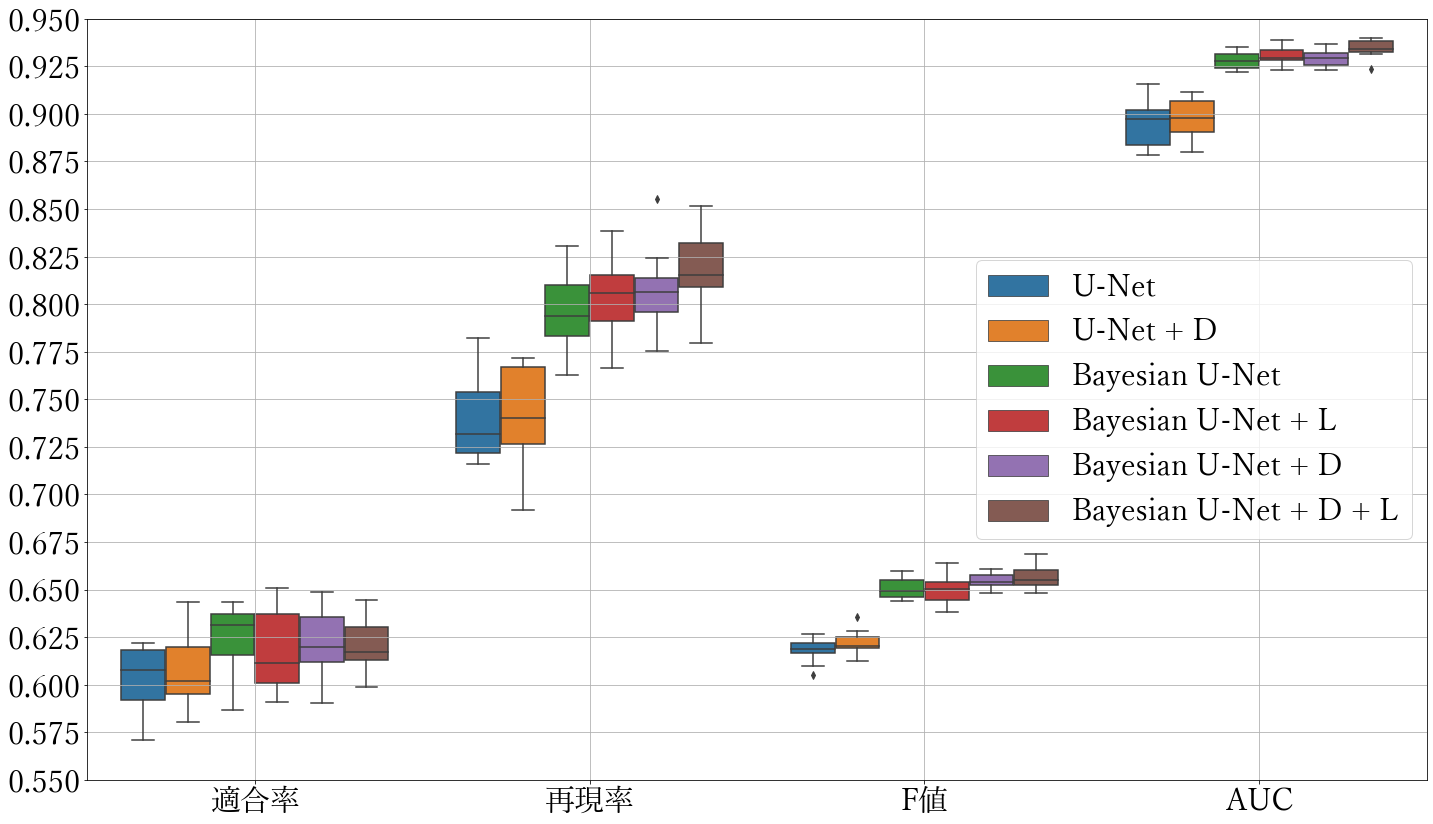

In [24]:
a = draw_boxplot()

UNet_D-aug1
UNet_D-aug5
BUNet_D-aug1
BUNet_D-aug5
BUNet_UD2-aug1
BUNet_UD2-aug5


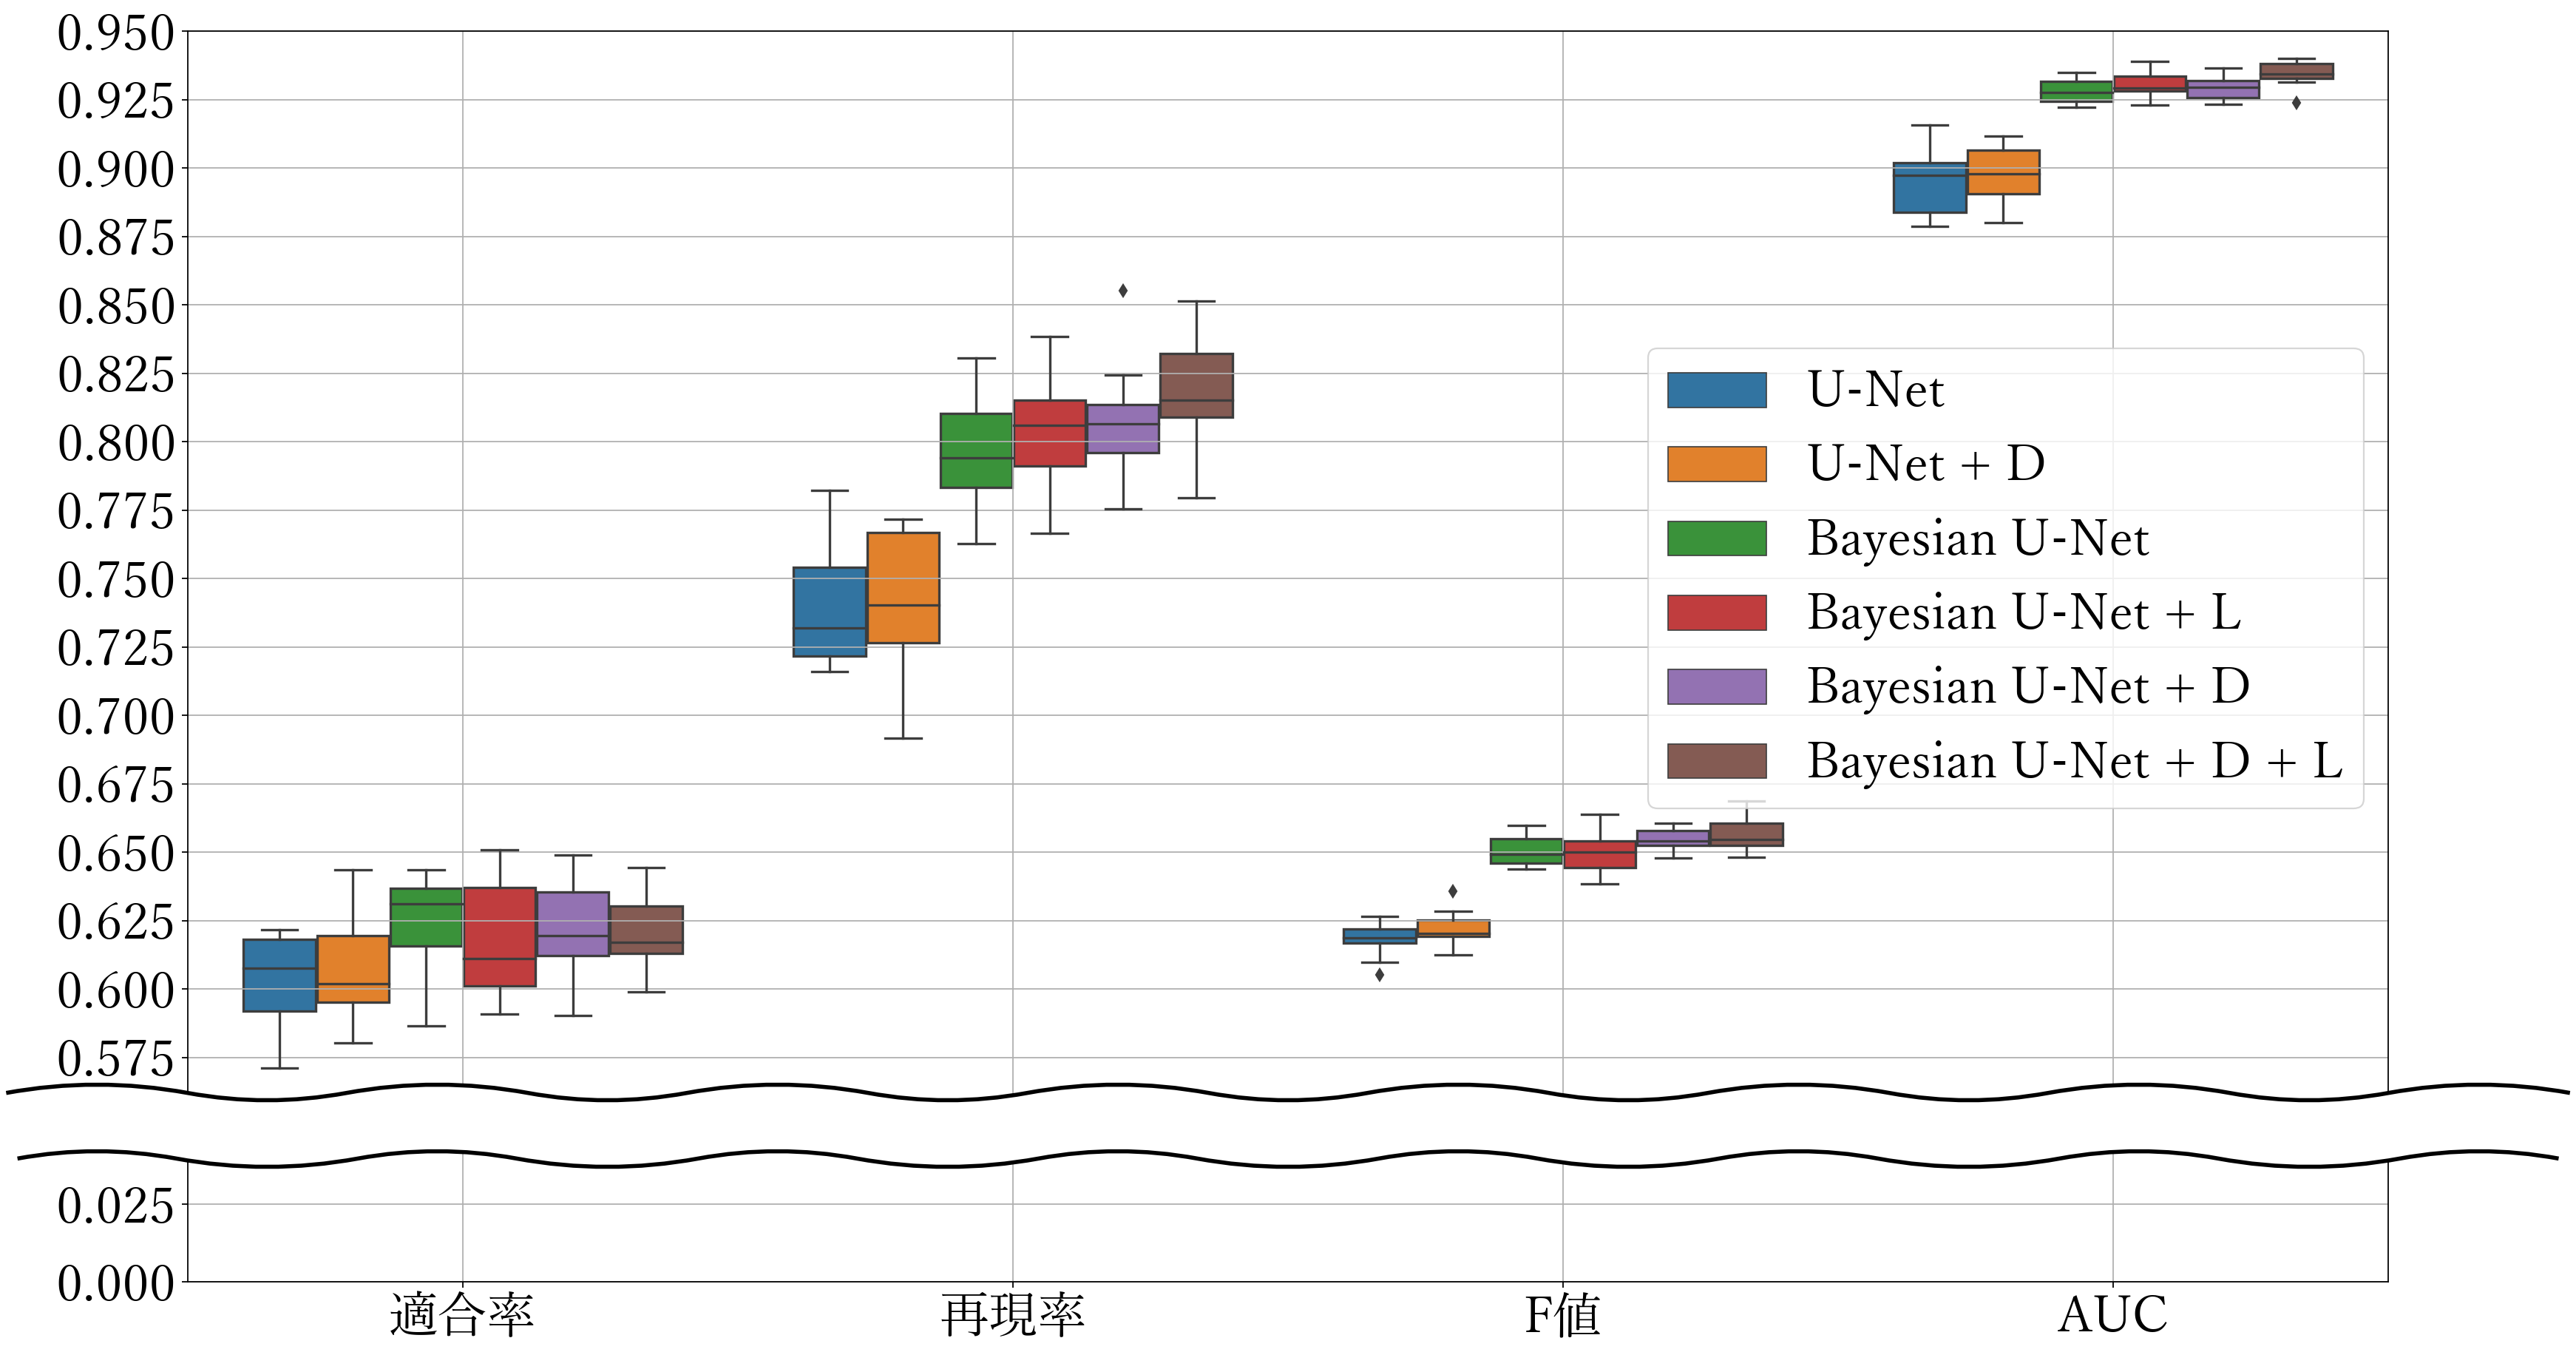

In [25]:
draw_boxplot2()

In [26]:
def comparescore():
    print("mean and std")
    print("-"*50)
    
    code = ""
    code += r"実験名 | 適合率 | 再現率 | F値 | AUC"
    code += "\n"
    for experiment_name in COMPARE_EXPERIMENT_NAMES:
        df_fm = pd.read_csv(os.path.join(ROOT_SAVE, experiment_name, "fundamental_metrics.csv"))
        df_auc_fm =  pd.read_csv(os.path.join(ROOT_SAVE, experiment_name, "fundamental_auc_metrics.csv"))
        df_metric_table = pd.merge(df_auc_fm, df_fm, how='left', on="seed")
        df_metric_table[["seed", "experiment_name", "precision", "recall", "f", "AUC"]].to_csv(os.path.join(ROOT_SAVE, experiment_name, "total_metrics.csv"), index=False)

        mean = df_metric_table.groupby("experiment_name")[["precision", "recall", "f", "AUC"]].mean().values.flatten().tolist()
        std = df_metric_table.groupby("experiment_name")[["precision", "recall", "f", "AUC"]].std().values.flatten().tolist()
        code += r"{} | {:.3f}±{:.3f} | {:.3f}±{:.3f} | {:.3f}±{:.3f} | {:.3f}±{:.3f}".format(ename2tname[experiment_name], mean[0], std[0], mean[1], std[1], mean[2], std[2], mean[3], std[3])
        code += "\n"
    
    print(code)
    print()

In [27]:
comparescore()

mean and std
--------------------------------------------------
実験名 | 適合率 | 再現率 | F値 | AUC
U-Net | 0.604±0.018 | 0.739±0.022 | 0.618±0.006 | 0.895±0.012
U-Net + D | 0.607±0.021 | 0.741±0.028 | 0.622±0.006 | 0.898±0.011
Bayesian U-Net | 0.625±0.018 | 0.796±0.021 | 0.651±0.006 | 0.928±0.005
Bayesian U-Net + D | 0.622±0.017 | 0.808±0.021 | 0.655±0.004 | 0.929±0.004
Bayesian U-Net + L | 0.617±0.021 | 0.805±0.022 | 0.650±0.008 | 0.930±0.005
Bayesian U-Net + D + L | 0.621±0.013 | 0.818±0.021 | 0.657±0.006 | 0.934±0.005




# MLFlow Client

In [28]:
experiment_name = EXPERIMENT_NAMES[0]
client = MlflowClient()
print(experiment_name)
experiment = client.get_experiment_by_name(experiment_name)
experiment_id = experiment.experiment_id
runs = client.list_run_infos(experiment_id)
n_runs = len(runs)
run = runs[0]
run_id = run.run_id
run.status

UNet_D-aug1


'FINISHED'

# Entropy

In [29]:
def entropy(p):
    if p == 0:
        return 0
    elif p == 1:
        return 0
    return - p * np.log2(p) - (1 - p) * np.log2(1 - p)

In [30]:
def entropy2(p, th=0.7):
    e = entropy(p)
    if e >= th:
        return e
    else:
        return th

In [31]:
p = np.arange(1e-7, 1-1e-7, 0.001)

In [32]:
y = np.vectorize(entropy)(p)
y2 = np.vectorize(entropy2)(p, th=0.7)

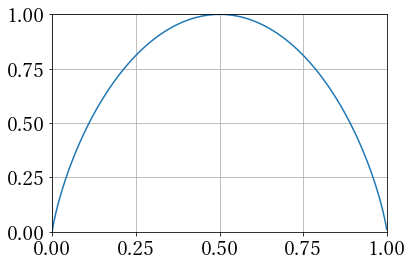

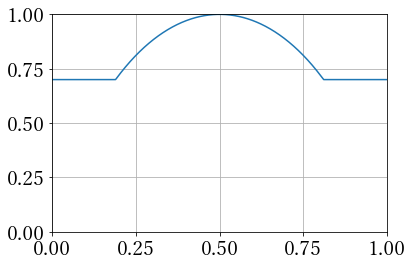

In [33]:
plt.plot(p, y)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.xticks(np.arange(0, 1.01, 0.25))
plt.yticks(np.arange(0, 1.01, 0.25))
plt.tick_params(labelsize=20)
plt.savefig(os.path.join(ROOT_SAVE, "entropy.png"))
plt.savefig(os.path.join(ROOT_SAVE, "entropy.pdf"))
plt.show()

plt.plot(p, y2)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.xticks(np.arange(0, 1.01, 0.25))
plt.yticks(np.arange(0, 1.01, 0.25))
plt.tick_params(labelsize=20)
plt.savefig(os.path.join(ROOT_SAVE, "entropy_t.png"))
plt.savefig(os.path.join(ROOT_SAVE, "entropy_t.pdf"))
plt.show()

In [34]:
ROOT_SAVE

'results'